## Effilab - business case

Effilab bids on keywords on Google Ads for its approximately 10,000 clients. The goal is to achieve the number of conversions promised to the client while spending an optimal budget on adwords. Currently, we have a model optimizing budget and cpc bid (cost per click bid) at the campaign level.

One of our goals to optimize the CPC is to understand the evolution of conversions in function of clicks and impressions.

- **impression**: number of times the ads was shown by Google to a user. It depends, among other factors, on the cpc bid.
- **CPC**: cost per click
- **average_position**: average position (rank) in Google result pages. 
- **click**: when a user clicks on an ad
- **conversion**: when a user did a specific action on the client's website (for example filling a form to get info).

### Environment

Libraries

- sklearn
- pandas
- dask
- numpy
- scipy
- matplotlib

If necessary, one can install an external dependancy using `pip install <library>`

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv(
    './dataset.csv',
    engine='python'
)

In [4]:
df.head()

,Unnamed: 0,customer_id,campaign_id,ad_group_id,keyword_id,keyword_text_matching_query,date,clicks,cost,impressions,conversions,avg_postion
0,0,1551288939,1484080226,56278671566,362396573757,+Décorateur +Peintre,2018-08-13,1,1.60,1,0.0,1.000000
1,1,1556604737,744170392,38463123585,94881345918,+Peinture +Niort,2018-08-24,1,0.94,1,0.0,2.000000
2,2,1559107978,1468647106,62493733088,389043783827,Taxi Remiremont,2018-08-02,3,1.76,5,0.0,1.000000
3,3,1568651041,1495197792,58813398638,376889097046,Serrurerie Merignac,2018-08-24,1,1.40,3,0.0,3.000000
4,4,1575898898,1078274555,53074066496,403784016698,Casse Automobile Guipavas,2018-08-14,2,0.41,7,0.0,2.128571


In [5]:
df.shape

(671614, 12)

The above data does not represent a list of bids but can be understand like so:

If a user matches a combination of keywords, we are willing to bid the **cost** (CPC). Each row matches a user having performed a keyword search in a day and for whom we have displayed an ad or not, if the bid hasn't been won. 

### **GOAL:** 

**Understand the evolution of conversions in function of clicks and impressions to optimize the CPC.**

A successful ad, will end in a conversion. Therefore, we need to focus on successful conversions. 

In [6]:
print("# successful conversions: {}".format(df[df['conversions'] >= 1.0].shape[0]))

# successful conversions: 9200


*There are 671 614 rows in the dataset and only 9200 successes. The # of successes represents 1.37% of all the data available. The data is strongly unbalanced. We are better off analyzing the data then training a model prone to bias.*

In [7]:
df[['clicks','cost','impressions','conversions','avg_postion']].describe()

,clicks,cost,impressions,conversions,avg_postion
count,671614.000000,671614.000000,671614.000000,671614.000000,670348.000000
mean,1.250647,1.325704,2.698785,0.013819,2.002858
std,1.142853,2.057545,17.301113,0.117806,1.245060
min,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,0.340000,1.000000,0.000000,1.000000
50%,1.000000,0.740000,1.000000,0.000000,1.714286
75%,1.000000,1.530000,2.000000,0.000000,3.000000
max,101.000000,133.840000,4412.000000,3.000000,11.000000


In the above description of our data, we notice some outliers: the max of cost is 133.84 and the max for impressions is 4412.0. Both of these values seem unlikely. 

In [8]:
df.loc[df['cost'].argmax]

Unnamed: 0                           356371
customer_id                      4848457658
campaign_id                      1419282179
ad_group_id                     55921954015
keyword_id                     298111539250
keyword_text_matching_query    +Nid +Guêpes
date                             2018-08-21
clicks                                   39
cost                                 133.84
impressions                             182
conversions                               1
avg_postion                         1.25714
Name: 356371, dtype: object

For this outlier, we see that **CPC = 133.84\$** , # of impressions is **182**, # of clicks is **39** and # of conversions is **1**. (Unless cost is the total cost.) It costed the company 5219.76\$ for 32 impressions out of 182 to clicked and have only one conversion.

In [9]:
df.loc[df['impressions'].argmax]

Unnamed: 0                          549965
customer_id                     2806996680
campaign_id                     1343520888
ad_group_id                    63061628108
keyword_id                        24283541
keyword_text_matching_query          velux
date                            2018-08-16
clicks                                   1
cost                                  7.78
impressions                           4412
conversions                              0
avg_postion                        1.00272
Name: 549965, dtype: object

For this outlier, we see that **CPC = 7.78\$**, # of impressions is **4412**, # of clicks is **1** and # of conversions is **0**. It cost the company 7.78\$ to get a single impression out of 4412 to be clicked on with no ROI. 

To understand the quality of our bidding, lets define the success rate of a bid as the probability that a winning bid will generate a conversion. 

**Success rate (SR) = (clicks / impressions) \* (conversions / clicks)**

Using the two outliers above:
* SR(1) = 0.00525
* SR(2) = 0

On the other hand, we should define the true cost or loss. Indeed, one can bid 1,000\$ CPC, generate 1,000 impressions and have no clicks, this will cost him nothing. The **True Cost (TC) = cpc \* clicks**

Therefore with the same outliers:
* TC(1) = 5219.76\$
* TC(2) = 7.78\$



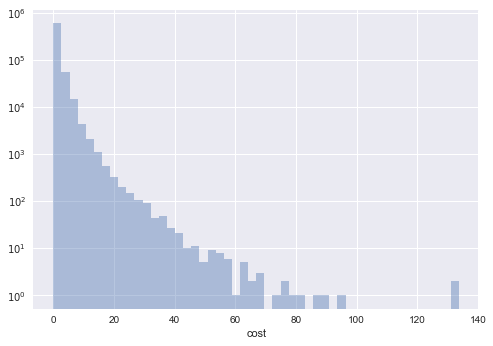

In [10]:
ax = sns.distplot(df['cost'],kde=False)
ax.set_yscale('log')

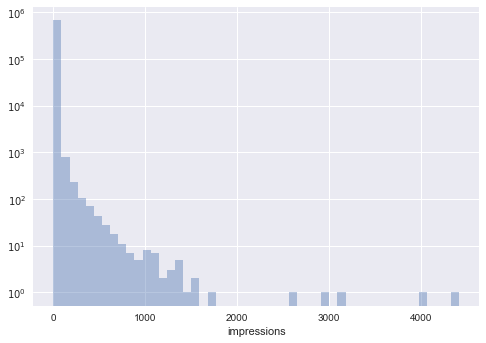

In [11]:
ax = sns.distplot(df['impressions'],kde=False)
ax.set_yscale('log')

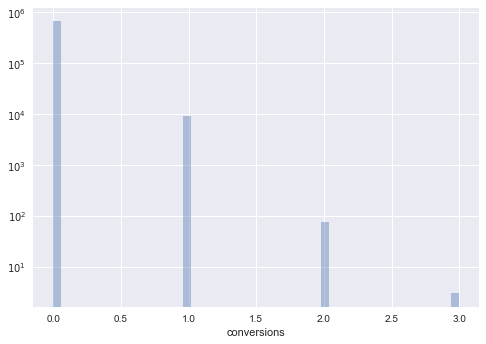

In [12]:
ax = sns.distplot(df['conversions'],kde=False)
ax.set_yscale('log')

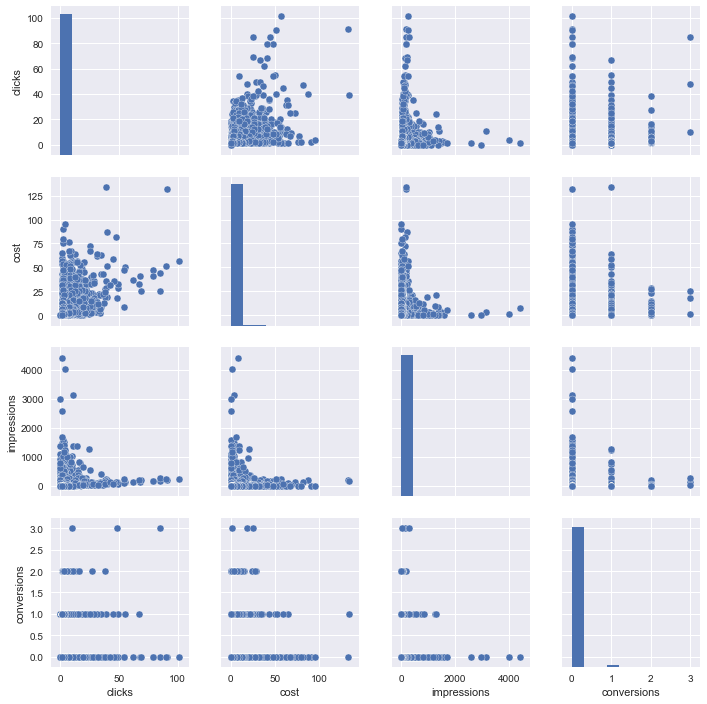

In [13]:
sns.pairplot(df[['clicks','cost','impressions','conversions']])

Correlation Matrix


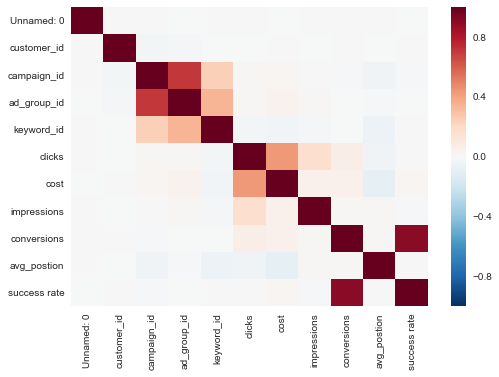

In [21]:
print("Correlation Matrix")
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values,yticklabels=corr.columns.values)

In this correlation matrix, we clearly see the lack of correlation between conversions and every other value except for clicks and cost. And clicks are correlated with impressions. Both of these observations are obvious.

Applying the Success Rate to our data

In [14]:
df['success rate'] = (df['clicks'] / df['impressions']) * (df['conversions'] / df['clicks']) 

In [15]:
df[df['success rate'] > 0]

,Unnamed: 0,customer_id,campaign_id,ad_group_id,keyword_id,keyword_text_matching_query,date,clicks,cost,impressions,conversions,avg_postion,success rate
23,23,1981953400,992972774,51267100276,332423377844,+Prix +Chape +Liquide,2018-08-28,1,0.96,6,1.0,2.000000,0.166667
62,62,1451166696,740942785,37972783639,62768405299,Jardinage Domicile,2018-08-17,2,1.30,2,1.0,3.000000,0.500000
75,75,2518150427,1408197043,55768246256,298905819785,+Maçonnerie +Entreprise,2018-08-31,3,2.64,2,1.0,2.500000,0.500000
195,195,4681269164,1057091228,52732597659,324323916376,+Societe +Demenageurs,2018-08-24,1,2.23,1,1.0,4.000000,1.000000
207,207,4915040676,806927517,48081109375,301249618476,+Volet +Troyes,2018-08-09,2,2.81,3,2.0,2.333333,0.666667
225,225,5393309776,1492972280,63174216888,297443208368,+Fosse +Septique,2018-08-17,3,8.48,5,1.0,1.400000,0.200000
287,287,6896861029,1360585408,51262562061,417142622626,Déménagement Petit Volume,2018-08-09,1,2.40,1,1.0,1.000000,1.000000
517,517,2185297915,849075003,45086639985,323041622092,Véranda Bioclimatique,2018-08-16,1,1.01,4,1.0,3.750000,0.250000
551,551,2827657396,1416036428,55985808416,452528377125,+Pisciniste +Saint +Malo,2018-08-02,1,1.09,2,1.0,1.000000,0.500000
575,575,3568701700,1070524507,54377811512,295849970606,Climatisation Automobile,2018-08-20,1,1.28,1,1.0,1.000000,1.000000


Using the computed success rate, we can easily see how effective a bidding strategy is. We can also see some surprising phenomena, for instance, we can observe multiple clicks for a single impression

In [16]:
df[df['success rate'] > 0].shape

(9176, 13)

In [17]:
df['success rate'] = df['success rate'].fillna(0)

In [18]:
df.loc[df['success rate'].argmax()]

Unnamed: 0                                  63677
customer_id                            3919463911
campaign_id                             999487148
ad_group_id                           56299003144
keyword_id                           369431224773
keyword_text_matching_query    +Brocanteur +Paris
date                                   2018-08-10
clicks                                          2
cost                                         0.52
impressions                                     1
conversions                                     2
avg_postion                                     1
success rate                                    2
Name: 63677, dtype: object

It would be interesting to compare the success rate based on the keywords used. 

In [19]:
df[(df['keyword_text_matching_query'].str.contains("portail") | df['keyword_text_matching_query'].str.contains("Portail"))   & df['success rate'] > 0].head()

,Unnamed: 0,customer_id,campaign_id,ad_group_id,keyword_id,keyword_text_matching_query,date,clicks,cost,impressions,conversions,avg_postion,success rate
908,908,2628423847,938559965,64203008388,453691051661,+Installateur +- +Portail +coulissant,2018-08-16,1,1.86,1,1.0,2.000,1.00
5462,5462,3537779176,1413844544,59684210150,297319684938,Portail Alu,2018-08-16,3,2.84,4,1.0,4.225,0.25
12072,12072,9804479642,1426663438,59814570601,300241813613,Motorisation Portail,2018-08-02,1,1.39,5,1.0,2.800,0.20
12802,12802,7222174435,1473448291,57837822380,307127801019,Portail Royan,2018-08-12,1,1.38,1,1.0,1.000,1.00
14533,14533,8760002623,1434553865,56257601476,345442780529,Portail Penmarch,2018-08-08,1,0.29,1,1.0,1.000,1.00


In [20]:
df[df['campaign_id'] == 938559965]

,Unnamed: 0,customer_id,campaign_id,ad_group_id,keyword_id,keyword_text_matching_query,date,clicks,cost,impressions,conversions,avg_postion,success rate
908,908,2628423847,938559965,64203008388,453691051661,+Installateur +- +Portail +coulissant,2018-08-16,1,1.86,1,1.0,2.0,1.0
44716,44716,2628423847,938559965,64203009348,453691053301,+pose +portail +- +prix,2018-08-06,1,2.28,1,0.0,2.0,0.0
232948,232948,2628423847,938559965,56553119682,298266754480,Fabricant Portail,2018-08-10,1,1.72,1,0.0,4.0,0.0
362366,362366,2628423847,938559965,64203009748,298266771240,Poser Portail,2018-08-08,2,3.72,1,0.0,2.0,0.0
597604,597604,2628423847,938559965,64203010268,296401258016,+poseur +portail,2018-08-10,1,1.66,1,0.0,2.0,0.0


We may also want to define the **cost of conversion = (clicks * CPC) / conversion** If there are no conversions, the cost of conversion is that of **clicks * CPC** because although there were no conversions, that's how much was spent.

In [50]:
df['conversion cost'] = np.where(df['conversions'] > 0, (df['clicks'] * df['cost']) / df['conversions'], (df['clicks'] * df['cost']))

In [51]:
df[df['conversion cost'] > 0].head()

,Unnamed: 0,customer_id,campaign_id,ad_group_id,keyword_id,keyword_text_matching_query,date,clicks,cost,impressions,conversions,avg_postion,success rate,conversion cost
0,0,1551288939,1484080226,56278671566,362396573757,+Décorateur +Peintre,2018-08-13,1,1.60,1,0.0,1.000000,0.0,1.60
1,1,1556604737,744170392,38463123585,94881345918,+Peinture +Niort,2018-08-24,1,0.94,1,0.0,2.000000,0.0,0.94
2,2,1559107978,1468647106,62493733088,389043783827,Taxi Remiremont,2018-08-02,3,1.76,5,0.0,1.000000,0.0,5.28
3,3,1568651041,1495197792,58813398638,376889097046,Serrurerie Merignac,2018-08-24,1,1.40,3,0.0,3.000000,0.0,1.40
4,4,1575898898,1078274555,53074066496,403784016698,Casse Automobile Guipavas,2018-08-14,2,0.41,7,0.0,2.128571,0.0,0.82


In [52]:
df[df['conversion cost'] > 0]['conversion cost'].describe()

count    617765.000000
mean          2.901493
std          27.784517
min           0.010000
25%           0.440000
50%           0.940000
75%           2.100000
max       12046.580000
Name: conversion cost, dtype: float64

Here we see how much each conversion cost. Because there are few conversions, there isn't much to analyze if we look at all the data. So we look at the description of all successful conversions. We see that the average conversion cost 2.90$.

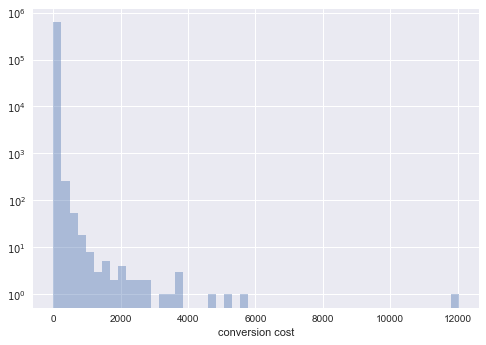

In [53]:
ax = sns.distplot(df[df['conversion cost'] > 0]['conversion cost'],kde=False)
ax.set_yscale('log')

With this distribution, we see some of the outlier, in particular one big one of 12,046.58$.

In [54]:
df[(df['conversion cost'] > 0) & (df['conversion cost'] < 4000)]['conversion cost'].describe()

count    617761.000000
mean          2.856839
std          20.144607
min           0.010000
25%           0.440000
50%           0.940000
75%           2.100000
max        3825.800000
Name: conversion cost, dtype: float64

We suppose that the CPC value matters independently for each campaign. So we want to analyze how the conversion cost changes for each campaign.

In [57]:
df.groupby(['campaign_id'])['conversion cost'].mean()

campaign_id
605239889     0.960667
614675200     2.440000
614675716     2.670000
616859692     1.558333
616859983     0.331429
616861333     0.931111
616861339     2.441250
616863337     1.117500
616863502     0.460000
616864798     4.243333
616864924     3.374762
616865677     0.803077
616865680     0.785161
616865725     0.774800
616865749     1.386667
616865926     0.690000
616870237     2.040000
616870984     1.622000
616871197     0.500000
616871926     0.353750
616871932     0.404375
616872178     1.211923
616888520     0.616923
616888523     0.680000
616888526     0.365000
616889975     0.160000
616891421     1.410678
616891424     2.380000
616892810     0.160000
616893332     1.751250
                ...   
1527805674    0.236000
1527806547    0.340000
1527806847    0.120000
1527808059    0.195000
1527808065    0.216000
1527811323    0.190000
1527814680    0.385000
1527814731    0.366667
1527814995    0.400000
1527815025    0.080000
1527815181    0.735000
1527815193    0.306000

In [62]:
df.groupby(['campaign_id'])['conversion cost'].aggregate(['mean','std','min','max'])

,mean,std,min,max
campaign_id,,,,
605239889,0.960667,1.590222,0.22,6.36
614675200,2.440000,NaN,2.44,2.44
614675716,2.670000,NaN,2.67,2.67
616859692,1.558333,1.540294,0.24,4.32
616859983,0.331429,0.087451,0.19,0.43
616861333,0.931111,0.592272,0.32,2.36
616861339,2.441250,2.431774,0.35,6.99
616863337,1.117500,1.681513,0.00,6.08
616863502,0.460000,0.309946,0.19,1.20


We see in the above table, how the cost of conversion varies from campaign. 

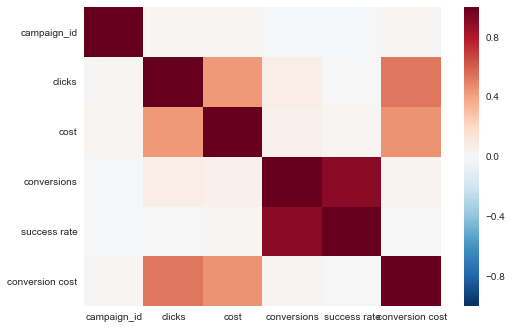

In [65]:
corr = df[['campaign_id','clicks','cost','conversions','success rate','conversion cost']].corr()
sns.heatmap(corr, xticklabels=corr.columns.values,yticklabels=corr.columns.values)

## Conclusion

It's hard to determine much from this data because it's not specific to each bid nor do we have enough conversions to assess what may impact successful conversion. Some of the column values are not clearly defined. We also do not know the budget for each campaign. This is a major element in any RTB environment. 

Our goal was to better understand the evolution of conversions based on clicks and impressions. However, it's clear that the more impressions, the more clicks and the more clicks, the more conversions.

While this is clearly observable, we have noticed that the cost of conversion varies for each campaign and that some campaign have a much higher conversion cost than others. These are likely to be the campaign for which we'll want to improve the CPC to reduce the Conversion Cost. 

This is a complex problem because we want to minimize the overall cost but maximize the number of conversions. If we lower the CPC, we are less likely to have high impressions, therefore less clicks and therefore less conversions. However, if we increase the CPC, we might be spending more for clicks we would have gotten with a lower CPC. Knowing the cost of conversion allows us to focus on a single variable. Our objective is to minimize it. 